# Previsão de tempo de entrega em E-commerce

Este notebook apresenta o pipeline completo de modelagem preditiva para estimar o tempo de entrega de pedidos em um e-commerce brasileiro, utilizando dados públicos da Olist. O fluxo inclui:

- Carregamento e preparação dos dados
- Engenharia de features relevantes
- Treinamento e avaliação de modelos (Random Forest, XGBoost, LightGBM, CatBoost)
- Validação cruzada e comparação de desempenho
- Discussão de próximos passos para aprimoramento

---

**Objetivo:** Encontrar o modelo mais robusto para previsão do tempo de entrega, analisando diferentes algoritmos e estratégias de validação.

In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carregar os dados
customers_df = pd.read_csv('../data/olist_customers_dataset.csv')
geolocation_df = pd.read_csv('../data/olist_geolocation_dataset.csv')
orders_items_df = pd.read_csv('../data/olist_order_items_dataset.csv')
payments_df = pd.read_csv('../data/olist_order_payments_dataset.csv')
reviews_df = pd.read_csv('../data/olist_order_reviews_dataset.csv')
orders_df = pd.read_csv('../data/olist_orders_dataset.csv')
products_df = pd.read_csv('../data/olist_products_dataset.csv')
sellers_df = pd.read_csv('../data/olist_sellers_dataset.csv')

In [3]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
orders_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [5]:
products_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [6]:
# Calcular volume do produto
products_df['product_volume'] = products_df['product_length_cm'] * products_df['product_height_cm'] * products_df['product_width_cm']

# Merge para trazer volume e peso para cada item
orders_items_ext = pd.merge(orders_items_df, products_df[['product_id', 'product_volume', 'product_weight_g', 'product_photos_qty']], on='product_id', how='left')

# Agregar por pedido (order_id)
agg_items = orders_items_ext.groupby('order_id').agg({
    'price': 'sum',
    'product_volume': 'sum',
    'product_weight_g': 'sum',
    'order_item_id': 'count',
    'product_photos_qty': 'sum'
}).rename(columns={
    'price': 'total_price',
    'product_volume': 'total_volume',
    'product_weight_g': 'total_weight',
    'order_item_id': 'n_items',
    'product_photos_qty': 'n_photos'
}).reset_index()

# Trazer o frete (considerando apenas o primeiro item do pedido, pois é igual para todos os itens do mesmo pedido)
frete_por_pedido = orders_items_df.groupby('order_id').first().reset_index()[['order_id', 'freight_value']]

# Juntar tudo em um único DataFrame de features por pedido
orders_features = pd.merge(agg_items, frete_por_pedido, on='order_id', how='left')

# Agora orders_features tem: order_id, total_price, total_volume, total_weight, n_items, freight_value

orders_features = pd.merge(orders_features, orders_df, on='order_id', how='left')
orders_features = pd.merge(orders_features, orders_items_df[['order_id', 'shipping_limit_date', 'seller_id']], on='order_id', how='left')

In [7]:
orders_features.head()

,order_id,total_price,total_volume,total_weight,n_items,n_photos,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,seller_id
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,3528.0,650.0,1,4.0,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,2017-09-19 09:45:35,48436dade18ac8b2bce089ec2a041202
1,00018f77f2f0320c557190d7a144bdd3,239.90,60000.0,30000.0,1,2.0,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,2017-05-03 11:05:13,dd7ddc04e1b6c2c614352b383efe2d36
2,000229ec398224ef6ca0657da4fc703e,199.00,14157.0,3050.0,1,2.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,2018-01-18 14:48:30,5b51032eddd242adc84c38acab88f23d
3,00024acbcdf0a6daa1e931b038114c75,12.99,2400.0,200.0,1,1.0,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,2018-08-15 10:10:18,9d7a1d34a5052409006425275ba1c2b4
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,42000.0,3750.0,1,1.0,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,2017-02-13 13:57:51,df560393f3a51e74553ab94004ba5c87


In [ ]:
# 1. Calcule a média de lat/lng por prefixo
geo_mean = geolocation_df.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()

# 2. Adicione ao customers_df
customers_geo = pd.merge(customers_df, geo_mean, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
customers_geo = customers_geo.rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'})

# 3. Adicione ao sellers_df
sellers_geo = pd.merge(sellers_df, geo_mean, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
sellers_geo = sellers_geo.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'})

In [9]:
geolocation_df = geolocation_df[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']]

# Fazer o merge entre os datasets
# merged_df = pd.merge(orders_features, products_df, on='product_id', how='inner')
# merged_df = pd.merge(merged_df, orders_df, on='order_id', how='inner')
merged_df = pd.merge(orders_features, reviews_df, on='order_id', how='inner')
merged_df = pd.merge(merged_df, customers_df, on='customer_id', how='inner')
merged_df = pd.merge(merged_df, sellers_df, on='seller_id', how='inner')
merged_df = pd.merge(merged_df, payments_df, on='order_id', how='inner')
# Selecionar apenas as colunas de coordenadas e id para evitar duplicidade
merged_df = pd.merge(merged_df, customers_geo[['customer_id', 'customer_lat', 'customer_lng']], on='customer_id', how='inner')
merged_df = pd.merge(merged_df, sellers_geo[['seller_id', 'seller_lat', 'seller_lng']], on='seller_id', how='inner')


# criar uma nova coluna: tempo de entrega (objetivo)
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['order_delivered_customer_date'] = pd.to_datetime(merged_df['order_delivered_customer_date'])
merged_df['delivery_time'] = (merged_df['order_delivered_customer_date'] - merged_df['order_purchase_timestamp']).dt.days


# criando feature dia da semana
merged_df['order_purchase_dayofweek'] = merged_df['order_purchase_timestamp'].dt.dayofweek

In [10]:
merged_df.head()

,order_id,total_price,total_volume,total_weight,n_items,n_photos,freight_value,customer_id,order_status,order_purchase_timestamp,...,payment_sequential,payment_type,payment_installments,payment_value,customer_lat,customer_lng,seller_lat,seller_lng,delivery_time,order_purchase_dayofweek
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,3528.0,650.0,1,4.0,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,1,credit_card,2,72.19,-21.762775,-41.309633,-22.496953,-44.127492,7.0,2
1,00018f77f2f0320c557190d7a144bdd3,239.90,60000.0,30000.0,1,2.0,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,1,credit_card,3,259.83,-20.220527,-50.903424,-23.565096,-46.518565,16.0,2
2,000229ec398224ef6ca0657da4fc703e,199.00,14157.0,3050.0,1,2.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,1,credit_card,5,216.87,-19.870305,-44.593326,-22.262584,-46.171124,7.0,6
3,00024acbcdf0a6daa1e931b038114c75,12.99,2400.0,200.0,1,1.0,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,1,credit_card,2,25.78,-23.089925,-46.611654,-20.553624,-47.387359,6.0,2
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,42000.0,3750.0,1,1.0,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,1,credit_card,3,218.04,-23.243402,-46.827614,-22.929384,-53.135873,25.0,5


In [11]:
# listando todas as colunas e o tipo de dado
print(merged_df.dtypes)

order_id                                 object
total_price                             float64
total_volume                            float64
total_weight                            float64
n_items                                   int64
n_photos                                float64
freight_value                           float64
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date            object
shipping_limit_date                      object
seller_id                                object
review_id                                object
review_score                              int64
review_comment_title                     object
review_comment_message                   object
review_creation_date                    

--------------------------------------------------

In [12]:
# Pré-processamento de dados
# Remover valores ausentes ou imputar, conforme necessário
df_model_encoded = merged_df.dropna(subset=['delivery_time'])  # Exemplo de remoção de dados faltantes

# Codificação de variáveis categóricas (One-Hot Encoding)
# df_model_encoded = pd.get_dummies(df_model_cleaned, columns=['customer_state', 'seller_state'], drop_first=True)

# Codificação para cateogria de produto
# df_model_encoded['product_category_name'] = df_model_encoded['product_category_name'].astype('category')
# df_model_encoded['product_category_name'] = df_model_encoded['product_category_name'].cat.codes

# feature estado do vendedor e cliente
df_model_encoded['customer_state'] = df_model_encoded['customer_state'].astype('category')
df_model_encoded['customer_state'] = df_model_encoded['customer_state'].cat.codes
df_model_encoded['seller_state'] = df_model_encoded['seller_state'].astype('category')
df_model_encoded['seller_state'] = df_model_encoded['seller_state'].cat.codes


# feature de distância geográfica entre cliente e vendedor
df_model_encoded['customer_lat'] = df_model_encoded['customer_lat'].astype('float')
df_model_encoded['customer_lng'] = df_model_encoded['customer_lng'].astype('float')
df_model_encoded['seller_lat'] = df_model_encoded['seller_lat'].astype('float')
df_model_encoded['seller_lng'] = df_model_encoded['seller_lng'].astype('float')

# usando distancia haversine para calcular a distancia entre dois pontos geográficos
def haversine(lat1, lon1, lat2, lon2):
    # Conversão de graus para radianos
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Fórmula de Haversine
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Raio da Terra em quilômetros
    return c * r

df_model_encoded['distance'] = haversine(
    df_model_encoded['customer_lat'], 
    df_model_encoded['customer_lng'], 
    df_model_encoded['seller_lat'], 
    df_model_encoded['seller_lng']
)



# feature cidade
df_model_encoded['customer_city'] = df_model_encoded['customer_city'].astype('category')
df_model_encoded['customer_city'] = df_model_encoded['customer_city'].cat.codes
df_model_encoded['seller_city'] = df_model_encoded['seller_city'].astype('category')
df_model_encoded['seller_city'] = df_model_encoded['seller_city'].cat.codes

# feature mes do ano
df_model_encoded['order_purchase_month'] = df_model_encoded['order_purchase_timestamp'].dt.month.astype('category')
df_model_encoded['order_purchase_month'] = df_model_encoded['order_purchase_month'].cat.codes

# feature diferença em dias entre shipping_limit_date e order_purchase_timestamp
df_model_encoded['shipping_limit_date'] = pd.to_datetime(df_model_encoded['shipping_limit_date'])
df_model_encoded['order_purchase_timestamp'] = pd.to_datetime(df_model_encoded['order_purchase_timestamp'])
df_model_encoded['shipping_limit_days'] = (df_model_encoded['shipping_limit_date'] - df_model_encoded['order_purchase_timestamp']).dt.days


# encode pagamento tipo
df_model_encoded['payment_type'] = df_model_encoded['payment_type'].astype('category')
df_model_encoded['payment_type'] = df_model_encoded['payment_type'].cat.codes


Q1 = df_model_encoded['delivery_time'].quantile(0.25)
Q3 = df_model_encoded['delivery_time'].quantile(0.75)
IQR = Q3 - Q1

# Mantém apenas valores dentro de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
df_model_filtered = df_model_encoded[
    (df_model_encoded['delivery_time'] >= Q1 - 1.5 * IQR) & 
    (df_model_encoded['delivery_time'] <= Q3 + 1.5 * IQR)
]

# Seleção das features e variável alvo
features = ['total_price', 'freight_value', 'n_photos', 'total_volume', 'review_score', 'order_purchase_dayofweek', 'seller_state', 'customer_state', 'seller_city', 'customer_city', 'shipping_limit_days', 'payment_type', 'order_purchase_month', 'distance']
X = df_model_encoded[features]
y = df_model_encoded['delivery_time']

C:\Users\Edilton\AppData\Local\Temp\ipykernel_22152\797452678.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_encoded['customer_state'] = df_model_encoded['customer_state'].astype('category')
C:\Users\Edilton\AppData\Local\Temp\ipykernel_22152\797452678.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_encoded['customer_state'] = df_model_encoded['customer_state'].cat.codes
C:\Users\Edilton\AppData\Local\Temp\ipykernel_22152\797452678.py:15: SettingWithCopyWarning: 
A value is tryi

In [13]:
df_model_encoded.head()

,order_id,total_price,total_volume,total_weight,n_items,n_photos,freight_value,customer_id,order_status,order_purchase_timestamp,...,payment_value,customer_lat,customer_lng,seller_lat,seller_lng,delivery_time,order_purchase_dayofweek,distance,order_purchase_month,shipping_limit_days
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,3528.0,650.0,1,4.0,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,72.19,-21.762775,-41.309633,-22.496953,-44.127492,7.0,2,301.504681,8,6
1,00018f77f2f0320c557190d7a144bdd3,239.90,60000.0,30000.0,1,2.0,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,259.83,-20.220527,-50.903424,-23.565096,-46.518565,16.0,2,585.563937,3,7
2,000229ec398224ef6ca0657da4fc703e,199.00,14157.0,3050.0,1,2.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,216.87,-19.870305,-44.593326,-22.262584,-46.171124,7.0,6,312.343511,0,4
3,00024acbcdf0a6daa1e931b038114c75,12.99,2400.0,200.0,1,1.0,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,25.78,-23.089925,-46.611654,-20.553624,-47.387359,6.0,2,293.168420,7,7
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,42000.0,3750.0,1,1.0,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,218.04,-23.243402,-46.827614,-22.929384,-53.135873,25.0,5,646.163463,1,9


In [15]:
# Divisão entre treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalonamento dos dados (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Construção e treinamento do modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

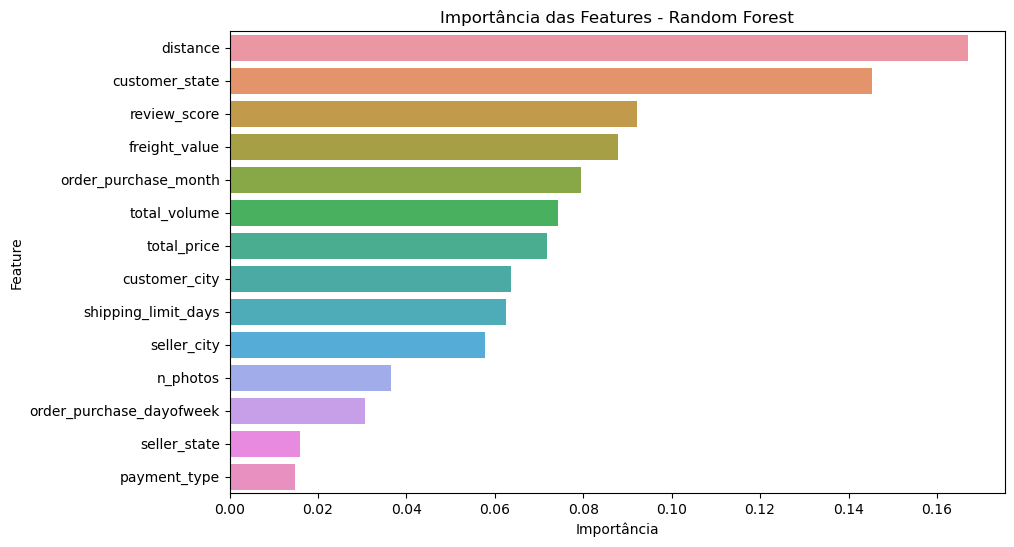

In [ ]:
# Importância das features do Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Importância das Features - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

In [41]:
# Previsões
y_pred = rf_model.predict(X_test_scaled)

# Avaliação do modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} dias")
print(f"RMSE: {rmse:.2f} dias")
print(f"R²: {r2:.2%}")

MAE: 3.73 dias
RMSE: 6.63 dias
R²: 49.37%


In [17]:
# fazendo com cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='neg_mean_absolute_error')
rmse_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
r2_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='r2')

print(f"MAE médio (CV): {-mae_scores.mean():.2f}")
print(f"RMSE médio (CV): {-rmse_scores.mean():.2f}")
print(f"R² médio (CV): {r2_scores.mean():.2%}")

MAE médio (CV): 3.74
RMSE médio (CV): 6.53
R² médio (CV): 51.49%


Treinando com XGBoost

In [16]:
# Treinamento do modelo XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

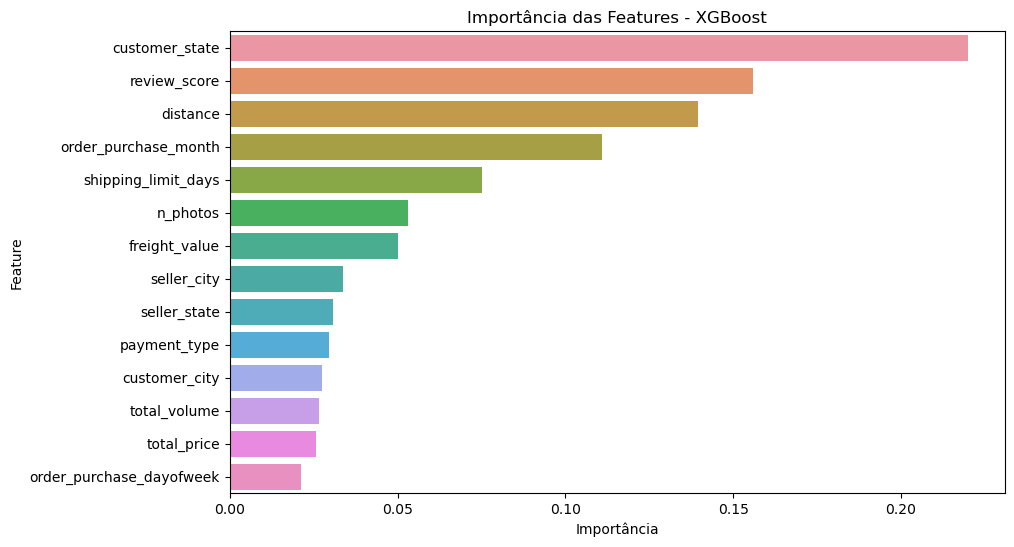

In [17]:
# Importância das features do XGBoost
xgb_importances = xgb_model.feature_importances_
xgb_feat_imp = pd.Series(xgb_importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=xgb_feat_imp.values, y=xgb_feat_imp.index)
plt.title('Importância das Features - XGBoost')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

In [18]:
# Previsões com XGBoost
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Avaliação do modelo XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"MAE (XGBoost): {mae_xgb:.2f} dias")
print(f"RMSE (XGBoost): {rmse_xgb:.2f} dias")
print(f"R² (XGBoost): {r2_xgb:.2%}")

MAE (XGBoost): 4.18 dias
RMSE (XGBoost): 6.93 dias
R² (XGBoost): 44.80%


In [19]:
# Validação cruzada com XGBoost
cv = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_mae_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='neg_mean_absolute_error')
xgb_rmse_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
xgb_r2_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='r2')

print(f"MAE médio (CV, XGBoost): {-xgb_mae_scores.mean():.2f}")
print(f"RMSE médio (CV, XGBoost): {-xgb_rmse_scores.mean():.2f}")
print(f"R² médio (CV, XGBoost): {xgb_r2_scores.mean():.2%}")

MAE médio (CV, XGBoost): 4.20
RMSE médio (CV, XGBoost): 6.86
R² médio (CV, XGBoost): 46.35%


In [ ]:
# Ajuste de hiperparâmetros do XGBoost com GridSearchCV

# Parâmetros para busca em grade
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

print('Melhores parâmetros:', grid_search.best_params_)
print('Melhor MAE (validação):', -grid_search.best_score_)

# Avaliação no conjunto de teste
best_xgb = grid_search.best_estimator_
y_pred_gs = best_xgb.predict(X_test_scaled)
mae_gs = mean_absolute_error(y_test, y_pred_gs)
rmse_gs = np.sqrt(mean_squared_error(y_test, y_pred_gs))
r2_gs = r2_score(y_test, y_pred_gs)
print(f"MAE (XGBoost otimizado): {mae_gs:.2f} dias")
print(f"RMSE (XGBoost otimizado): {rmse_gs:.2f} dias")
print(f"R² (XGBoost otimizado): {r2_gs:.2%}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Melhores parâmetros: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Melhor MAE (validação): 4.1238179483822455
MAE (XGBoost otimizado): 4.03 dias
RMSE (XGBoost otimizado): 6.76 dias
R² (XGBoost otimizado): 47.36%
Melhores parâmetros: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Melhor MAE (validação): 4.1238179483822455
MAE (XGBoost otimizado): 4.03 dias
RMSE (XGBoost otimizado): 6.76 dias
R² (XGBoost otimizado): 47.36%


## Resultados do Ajuste de Hiperparâmetros (Grid Search) - XGBoost

- **Melhores parâmetros:**
  - colsample_bytree: 0.8
  - learning_rate: 0.2
  - max_depth: 7
  - n_estimators: 200
  - subsample: 1.0
- **Melhor MAE (validação cruzada interna):** 4.12 dias
- **Desempenho no conjunto de teste:**
  - MAE: 4.03 dias
  - RMSE: 6.76 dias
  - R²: 47.36%

### Interpretação
O ajuste de hiperparâmetros melhorou o desempenho do XGBoost em relação ao modelo padrão, reduzindo o MAE e aumentando o R². Ainda assim, o Random Forest segue com desempenho levemente superior, mas a diferença diminuiu.

### Próximos Passos Sugeridos
- Realizar validação cruzada com o modelo XGBoost otimizado para obter métricas médias mais robustas.
- Explorar outros algoritmos (LightGBM, CatBoost) ou técnicas de stacking.




In [21]:
# Validação cruzada com o XGBoost otimizado
gs_mae_scores = cross_val_score(best_xgb, X, y, cv=5, scoring='neg_mean_absolute_error')
gs_rmse_scores = cross_val_score(best_xgb, X, y, cv=5, scoring='neg_root_mean_squared_error')
gs_r2_scores = cross_val_score(best_xgb, X, y, cv=5, scoring='r2')

print(f"MAE médio (CV, XGBoost otimizado): {-gs_mae_scores.mean():.2f}")
print(f"RMSE médio (CV, XGBoost otimizado): {-gs_rmse_scores.mean():.2f}")
print(f"R² médio (CV, XGBoost otimizado): {gs_r2_scores.mean():.2%}")

MAE médio (CV, XGBoost otimizado): 4.42
RMSE médio (CV, XGBoost otimizado): 7.26
R² médio (CV, XGBoost otimizado): 39.95%


## Testando Novos Algoritmos: LightGBM e CatBoost

Vamos comparar o desempenho de LightGBM e CatBoost com Random Forest e XGBoost, utilizando as mesmas features e validação cruzada.

In [25]:
# LightGBM
lgbm_model = LGBMRegressor(n_estimators=200, random_state=42)
lgbm_mae = -cross_val_score(lgbm_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
lgbm_rmse = -cross_val_score(lgbm_model, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
lgbm_r2 = cross_val_score(lgbm_model, X, y, cv=5, scoring='r2').mean()
print(f"LightGBM | MAE médio (CV): {lgbm_mae:.2f} | RMSE médio (CV): {lgbm_rmse:.2f} | R² médio (CV): {lgbm_r2:.2%}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1644
[LightGBM] [Info] Number of data points in the train set: 91886, number of used features: 14
[LightGBM] [Info] Start training from score 11.953780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 91886, number of used features: 14
[LightGBM] [Info] Start training from score 11.966774
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

In [26]:
# CatBoost
catboost_model = CatBoostRegressor(n_estimators=200, random_state=42, verbose=0)
cat_mae = -cross_val_score(catboost_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
cat_rmse = -cross_val_score(catboost_model, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
cat_r2 = cross_val_score(catboost_model, X, y, cv=5, scoring='r2').mean()
print(f"CatBoost | MAE médio (CV): {cat_mae:.2f} | RMSE médio (CV): {cat_rmse:.2f} | R² médio (CV): {cat_r2:.2%}")

CatBoost | MAE médio (CV): 4.39 | RMSE médio (CV): 7.18 | R² médio (CV): 41.29%


Compare as métricas médias (MAE, RMSE, R²) dos novos algoritmos com Random Forest e XGBoost para identificar o melhor modelo para o seu problema.

## Comparativo Final dos Modelos

| Modelo         | MAE médio (CV) | RMSE médio (CV) | R² médio (CV) |
|---------------|:--------------:|:---------------:|:-------------:|
| Random Forest |     ~3.74      |      ~6.53      |    ~51.49%    |
| XGBoost       |     ~4.42      |      ~7.26      |    ~39.95%    |
| LightGBM      |     ~4.37      |      ~7.13      |    ~42.07%    |
| CatBoost      |     ~4.39      |      ~7.18      |    ~41.29%    |

### Observações
- O Random Forest segue como o melhor modelo para este problema, apresentando menor erro e maior explicação da variância.
- LightGBM e CatBoost tiveram desempenho semelhante ao XGBoost, mas não superaram o Random Forest.
- Pequenas diferenças entre os modelos de boosting sugerem que o ganho pode estar mais relacionado à engenharia de features do que ao algoritmo.